In [1]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as  plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from pmdarima.arima import auto_arima
from sklearn import metrics

In [2]:
df = pd.read_csv(r'E:\Dokumenty\GitHub\gold-forecast\data\data_nominal_clean.csv', sep=';',  index_col='date',  parse_dates=['date'], usecols=['date','Gold'])
df.head()

,Gold
date,
1986-01-02,326.30
1986-01-03,326.75
1986-01-06,328.00
1986-01-07,330.00
1986-01-08,332.60


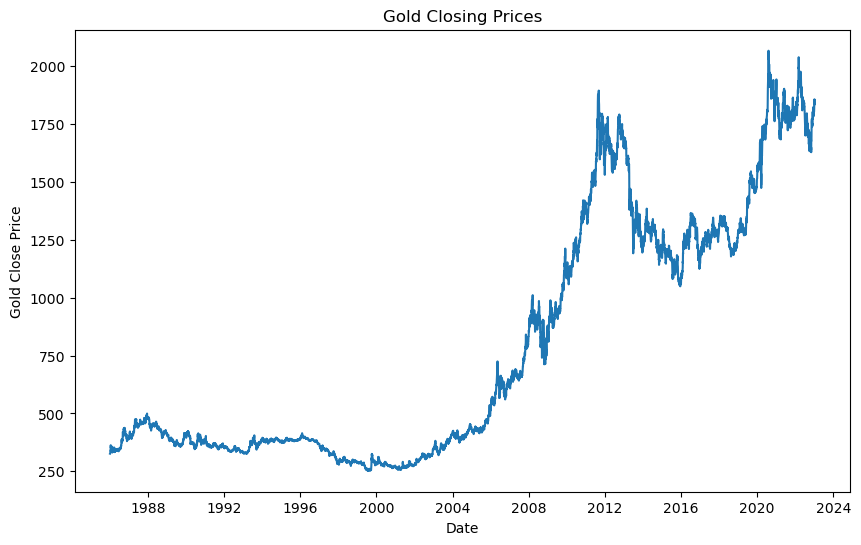

In [3]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Gold Close Price')
plt.plot(df['Gold'])
plt.title('Gold Closing Prices')
plt.show()

Text(0.5, 1.0, 'Histogram of Gold Prices')

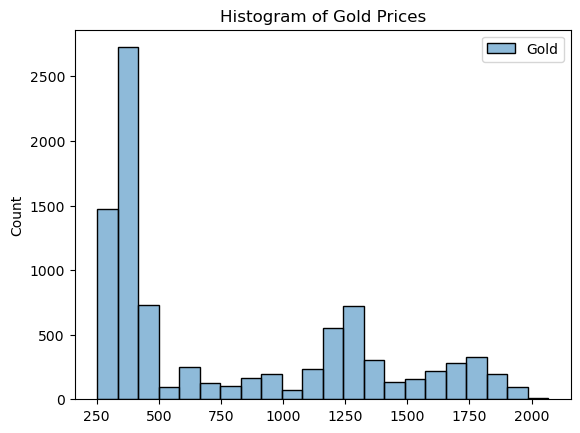

In [4]:
sns.histplot(df)
plt.title('Histogram of Gold Prices')

<AxesSubplot:ylabel='Density'>

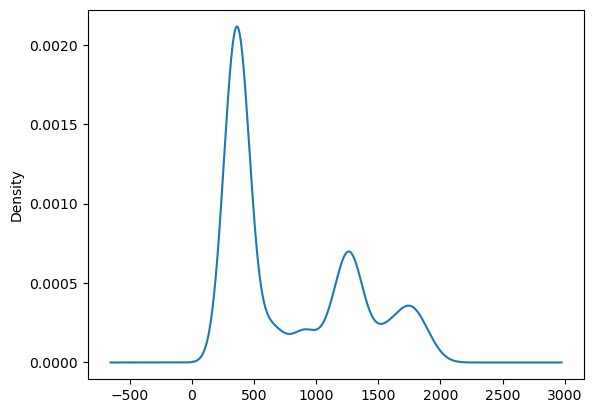

In [5]:
df.Gold.plot(kind='kde')

e:\anaconda\envs\thesis\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


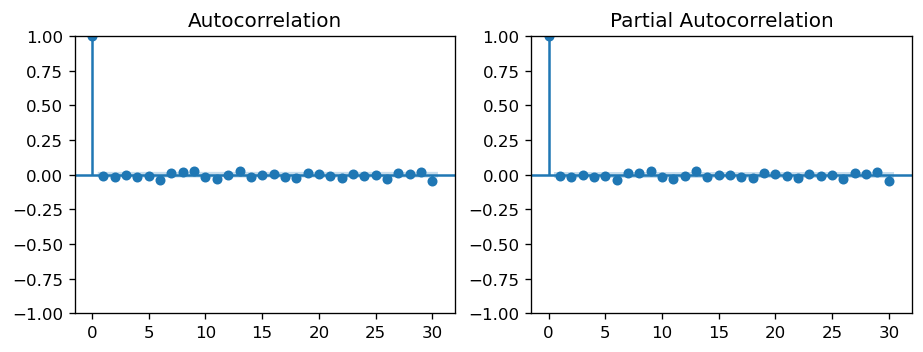

In [9]:
dfac = df.copy()
dfac.reset_index(inplace=True, drop=True)

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
plot_acf(dfac['Gold'].diff().dropna(), ax=axes[0], lags=30)
plot_pacf(dfac['Gold'].diff().dropna(), ax=axes[1], lags=30)

plt.show()

In [10]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

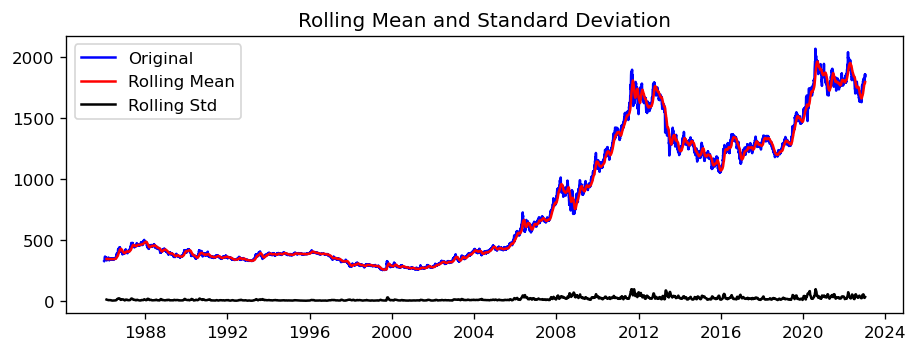

Results of dickey fuller test
Test Statistics                   0.275366
p-value                           0.976186
No. of lags used                 30.000000
Number of observations used    9118.000000
critical value (1%)              -3.431067
critical value (5%)              -2.861857
critical value (10%)             -2.566939
dtype: float64


In [11]:
test_stationarity(df['Gold'])

<Figure size 1080x360 with 0 Axes>

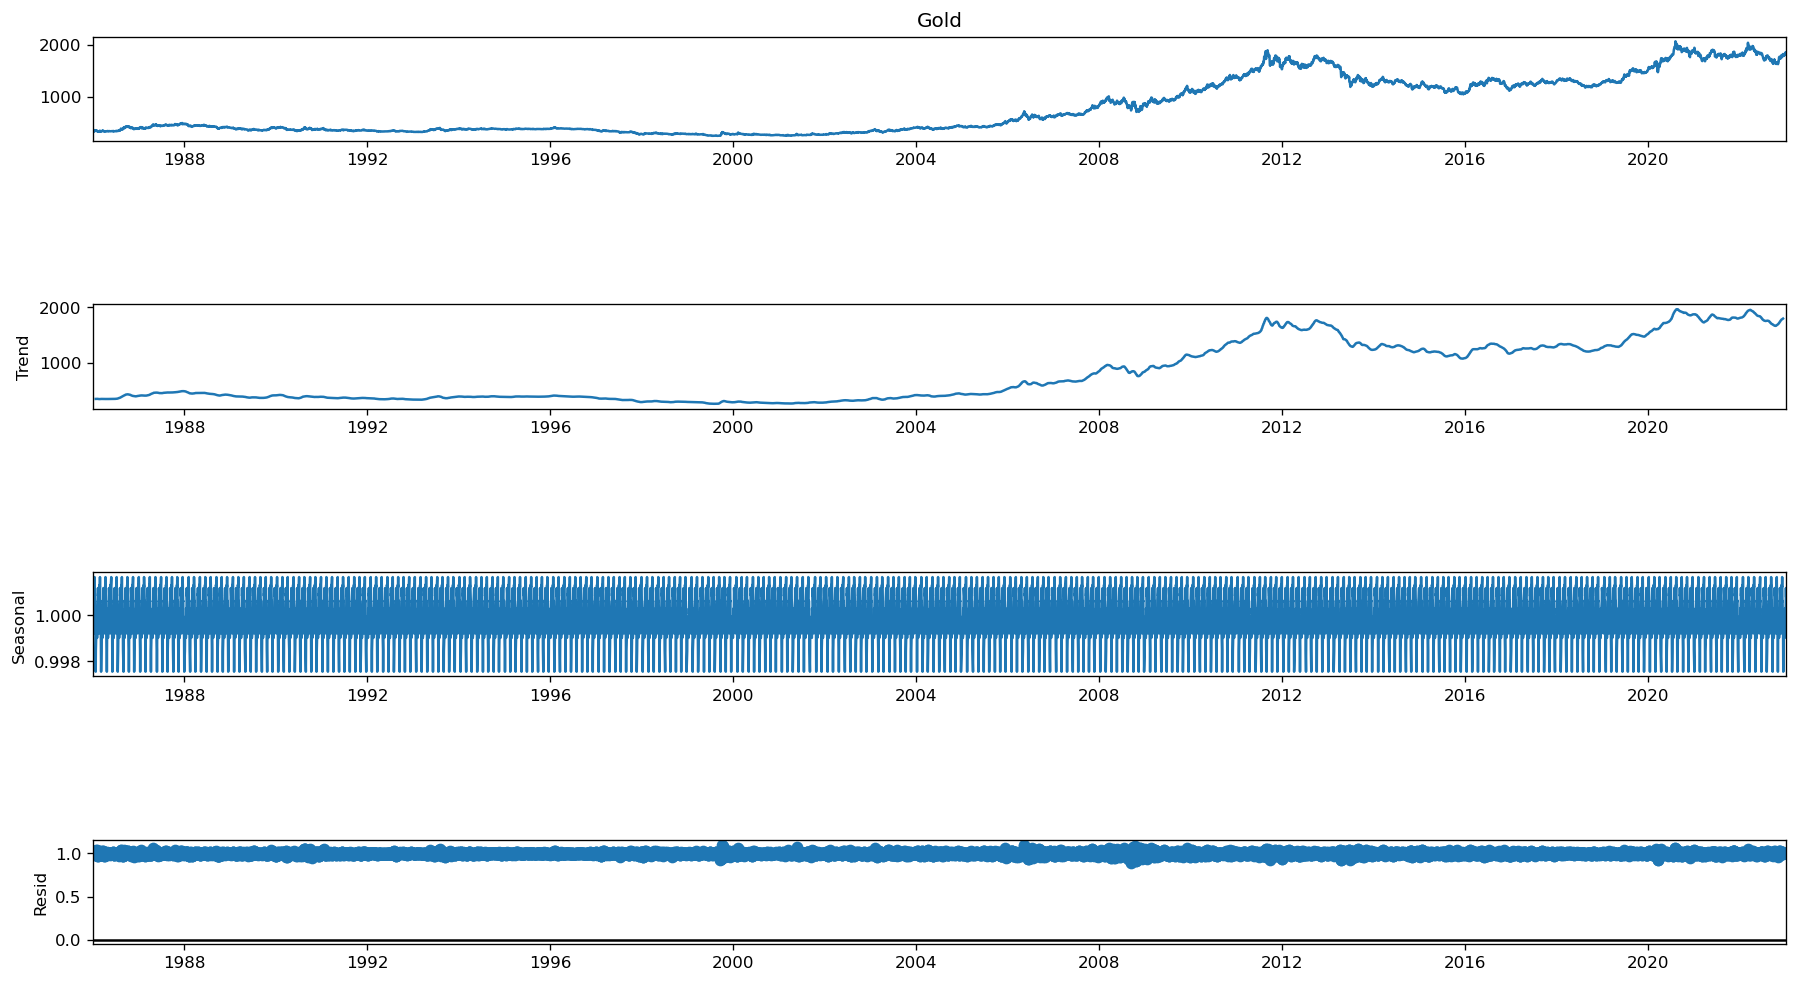

In [12]:
sd_plot  = seasonal_decompose(df['Gold'], model='multiplicative', period=30)
fig = plt.figure()
fig = sd_plot.plot()
fig.set_size_inches(16,10)

Detrending time series 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


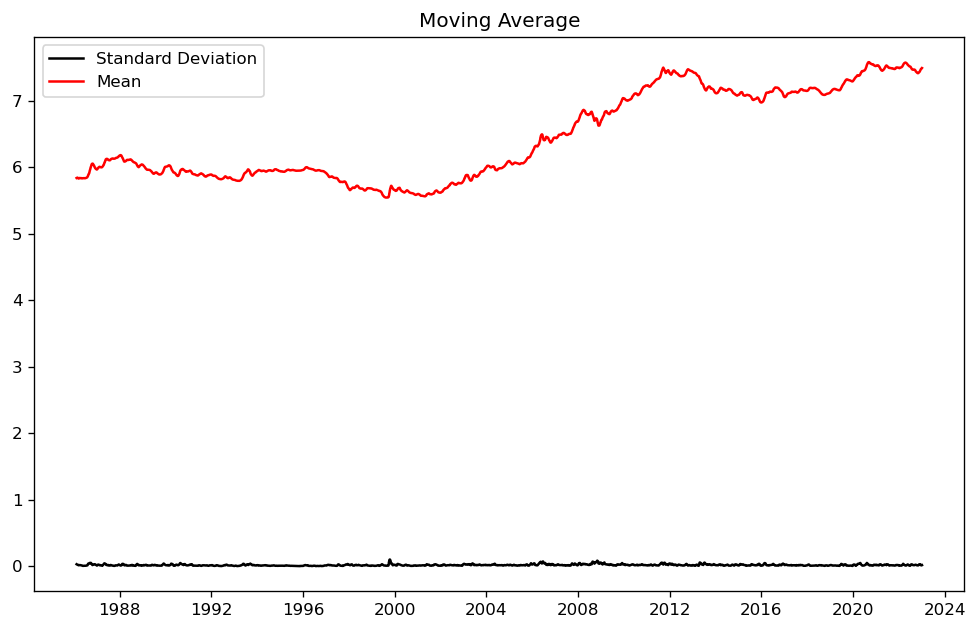

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df)
moving_avg = df_log.rolling(30).mean()
std_dev = df_log.rolling(30).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Data split

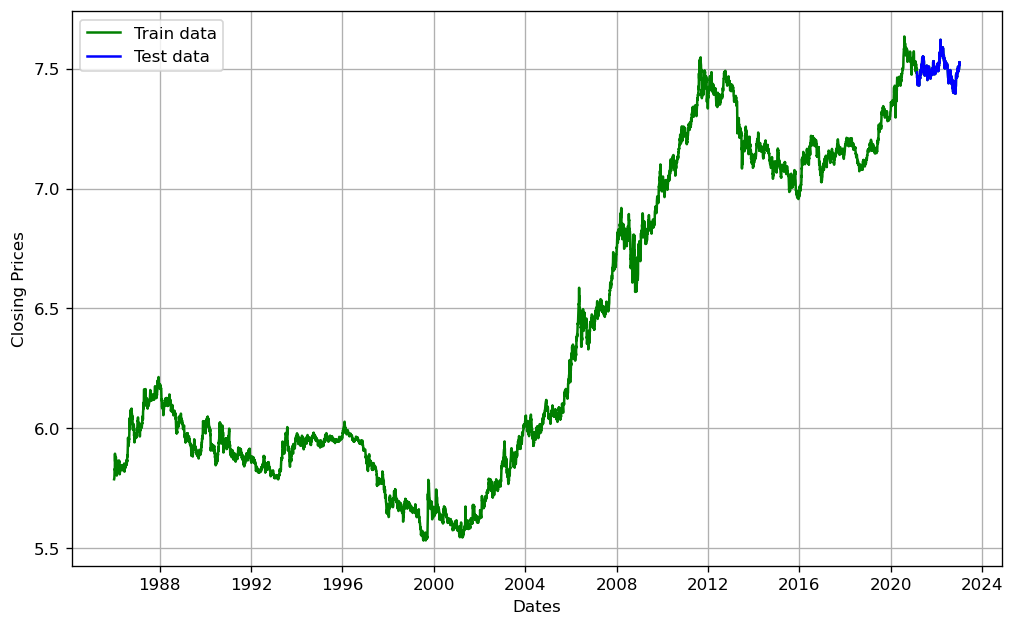

In [14]:
train_data, test_data = df_log[3:int(len(df_log)*0.95)], df_log[int(len(df_log)*0.95):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-55248.829, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-55249.985, Time=1.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-55250.552, Time=1.42 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-55250.580, Time=2.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-55248.737, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-55248.662, Time=2.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-55248.788, Time=3.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-55246.637, Time=5.00 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-55249.217, Time=0.91 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 17.954 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8688
Model:               SARIMAX(0, 1, 1)   Log Likelihood               27628.290
Date:                Tue, 14 M

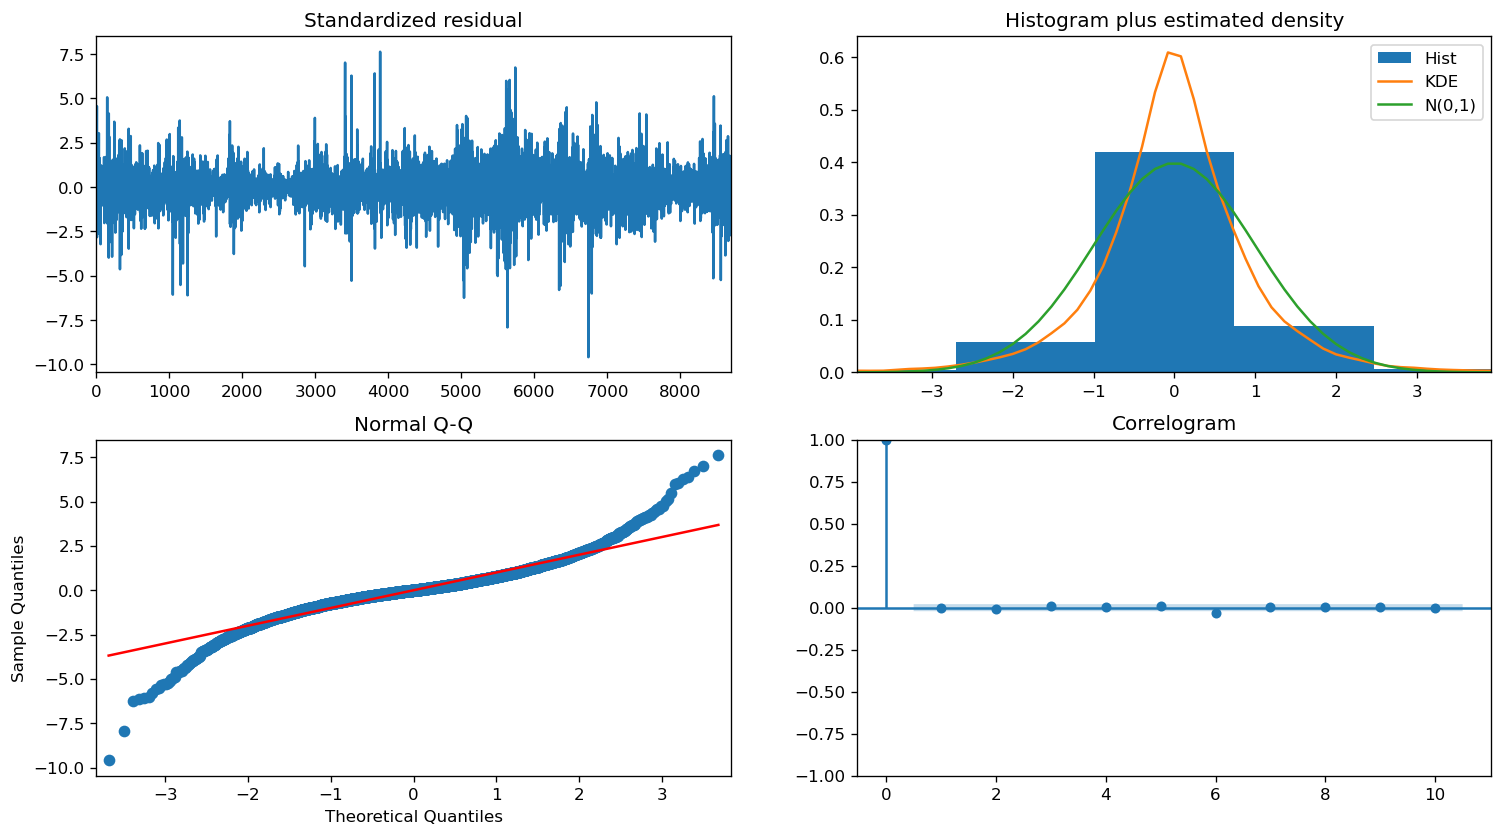

In [26]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      max_order=60)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Fitting  model sugessted above

In [16]:
model = ARIMA(train_data, order=(0,1,1))  
fitted = model.fit()  
print(fitted.summary())

e:\anaconda\envs\thesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\anaconda\envs\thesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\anaconda\envs\thesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   Gold   No. Observations:                 8688
Model:                 ARIMA(0, 1, 1)   Log Likelihood               27626.608
Date:                Tue, 14 Mar 2023   AIC                         -55249.217
Time:                        17:32:16   BIC                         -55235.078
Sample:                             0   HQIC                        -55244.397
                               - 8688                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0169      0.007     -2.278      0.023      -0.031      -0.002
sigma2         0.0001   7.43e-07    136.280      0.000    9.97e-05       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [17]:
fc = fitted.forecast(steps  = 458, alpha=0.05)

e:\anaconda\envs\thesis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [75]:
import statsmodels
statsmodels.__version__

'0.13.5'

In [60]:
fc

8688    7.488964
8689    7.488964
8690    7.488964
8691    7.488964
8692    7.488964
          ...   
9141    7.488964
9142    7.488964
9143    7.488964
9144    7.488964
9145    7.488964
Name: predicted_mean, Length: 458, dtype: float64

In [18]:
fc = pd.DataFrame(fc)
fc.index = test_data.index
fc

,predicted_mean
date,
2021-02-25,7.488964
2021-02-26,7.488964
2021-03-01,7.488964
2021-03-02,7.488964
2021-03-03,7.488964
...,...
2022-12-30,7.488964
2023-01-03,7.488964
2023-01-04,7.488964


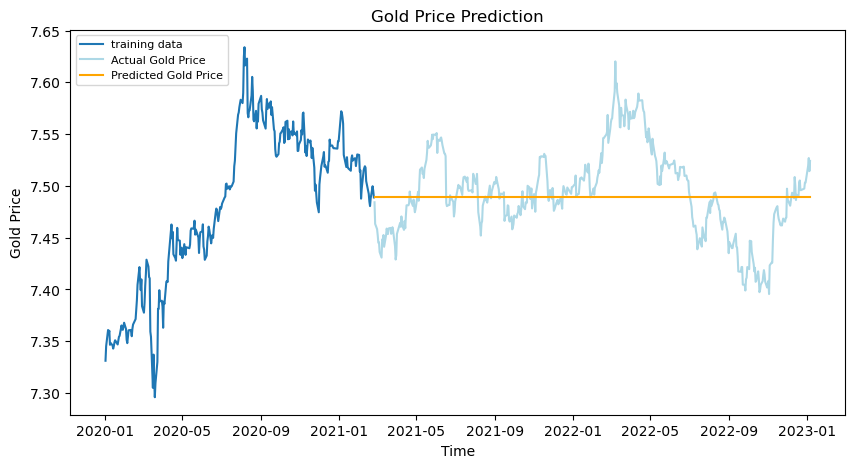

In [19]:
#fc_series = pd.Series(fc, index=test_data.index)
#lower_series = pd.Series(conf[:, 0], index=test_data.index)
#upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data[train_data.index > '2019-12-31'], label='training data')
plt.plot(test_data, color = 'lightblue', label='Actual Gold Price')
plt.plot(fc['predicted_mean'], color = 'orange',label='Predicted Gold Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('Gold Price Prediction')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [58]:
test_data

,Gold
date,
2021-02-25,7.484172
2021-02-26,7.463277
2021-03-01,7.458273
2021-03-02,7.452315
2021-03-03,7.445067
...,...
2022-12-30,7.503152
2023-01-03,7.519286
2023-01-04,7.526879
